In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import lightgbm as lgb
import xgboost as xgb
import catboost as cb

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_log_error

## 读入数据

In [2]:
train_df = pd.read_csv('../input/train.csv')

test_df = pd.read_csv('../input/test.csv')

In [3]:
abalone_cols = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight', 'Rings']

In [4]:
ext_df = pd.read_csv('../input/abalone.data', names=abalone_cols)

In [5]:
ext_df.shape[0]

4177

In [6]:
ext_df.head()

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [7]:
train_df.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


## 特征工程

In [8]:
com_df = pd.concat([train_df, ext_df, test_df], axis=0, ignore_index=True)

In [9]:
nums_train = train_df.shape[0] + ext_df.shape[0]
nums_train

94792

In [11]:
train_idx = com_df.index[:nums_train]
test_idx = com_df.index[nums_train:]

In [14]:
train_idx.shape[0], test_idx.shape[0]

(94792, 60411)

### Sex

In [15]:
Sex2code = {'I': 0, 'M': 1, 'F': 2}

In [16]:
com_df['Sex_code'] = com_df['Sex'].map(Sex2code)

In [17]:
com_df.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings,Sex_code
0,0.0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11.0,2
1,1.0,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11.0,2
2,2.0,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6.0,0
3,3.0,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10.0,1
4,4.0,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9.0,0


### Rings

In [13]:
# com_df['Rings_log1p'] = np.log1p(com_df['Rings'])

## cross_validation

## 调参

[bayesHyperTuning.py](bayesHyperTuning.py)

## 建模

In [18]:
train_df = com_df.loc[train_idx]
test_df = com_df.loc[test_idx]

In [19]:
train_df.shape[0], test_df.shape[0]

(94792, 60411)

In [20]:
train_cols = [c for c in train_df.columns if c not in {'id', 'Rings', 'Rings_log1p', 'Sex'}]

In [21]:
train_cols

['Length',
 'Diameter',
 'Height',
 'Whole weight',
 'Whole weight.1',
 'Whole weight.2',
 'Shell weight',
 'Sex_code']

In [22]:
target_col = 'Rings'

In [23]:
# 记录各次试验的结果
oof_df = train_df[['id', 'Rings']].copy()
pred_df = test_df[['id']].copy()

In [25]:
pred_df['id'] = pred_df['id'].astype(int)

### lightgbm

#### 默参

In [27]:
params = {
    'num_threads': 8,
    'objective': 'regression',
    'num_leaves': 31,
    'min_data_in_leaf': 20,
    'bagging_fraction': 1.0,
    'feature_fraction': 1.0,
    'reg_alpha': 0.0,
    'metric': 'l2',
    'early_stopping_rounds': 400,
}

In [28]:
nfold = 5
folds = KFold(n_splits=nfold, shuffle=True, random_state=42)

oof = np.zeros(train_df.shape[0])
pred = np.zeros(test_df.shape[0])

for i, (trn_idx, val_idx) in enumerate(folds.split(train_df.index)):
    print(f'fold={i}', '- ' * 20)
    trn_data = lgb.Dataset(train_df.loc[trn_idx, train_cols], label=train_df.loc[trn_idx, target_col], categorical_feature=['Sex_code'])
    val_data = lgb.Dataset(train_df.loc[val_idx, train_cols], label=train_df.loc[val_idx, target_col], categorical_feature=['Sex_code'])

    model = lgb.train(params, trn_data, 10000, valid_sets=val_data, callbacks=[lgb.log_evaluation(100)])

    oof[val_idx] = model.predict(train_df.loc[val_idx, train_cols], num_iteration=model.best_iteration)
    pred += model.predict(test_df[train_cols], num_iteration=model.best_iteration) / nfold

fold=0 - - - - - - - - - - - - - - - - - - - - 
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1333
[LightGBM] [Info] Number of data points in the train set: 75833, number of used features: 8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 9.711972
Training until validation scores don't improve for 400 rounds
[100]	valid_0's l2: 3.47584
[200]	valid_0's l2: 3.42776
[300]	valid_0's l2: 3.40394
[400]	valid_0's l2: 3.39372
[500]	valid_0's l2: 3.39445
[600]	valid_0's l2: 3.39006
[700]	valid_0's l2: 3.39919
[800]	valid_0's l2: 3.40968
[900]	valid_0's l2: 3.41138
[1000]	valid_0's l2: 3.41367
Early stopping, best iteration is:
[600]	val

In [29]:
mean_squared_log_error(train_df['Rings'], oof, squared=False)

0.14999862448969184

##### 抽象成函数

In [31]:
def lgb_cv(params, train_df, test_df, train_cols, target_col, log_transform=False, stratified=False, nfold=5, num_boost_round=10000):
    if stratified:
        folds = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits=nfold, shuffle=True, random_state=42)

    target = train_df[target_col]
    if log_transform:
        target = np.log1p(train_df[target_col])
    
    oof = np.zeros(train_df.shape[0])
    pred = np.zeros(test_df.shape[0])
    
    for i, (trn_idx, val_idx) in enumerate(folds.split(train_df.index, train_df.Rings.astype(int))):
    # for i, (trn_idx, val_idx) in enumerate(folds.split(train_df.index)):
        print(f'fold={i}', '- ' * 20)
        trn_data = lgb.Dataset(train_df.loc[trn_idx, train_cols], label=target.loc[trn_idx], categorical_feature=['Sex_code'])
        val_data = lgb.Dataset(train_df.loc[val_idx, train_cols], label=target.loc[val_idx], categorical_feature=['Sex_code'])
    
        model = lgb.train(params, trn_data, num_boost_round, valid_sets=val_data, callbacks=[lgb.log_evaluation(200)])
    
        oof[val_idx] = model.predict(train_df.loc[val_idx, train_cols], num_iteration=model.best_iteration)
        pred += model.predict(test_df[train_cols], num_iteration=model.best_iteration) / nfold

    if log_transform:
        oof = np.expm1(oof)
        pred = np.expm1(pred)

    cv = mean_squared_log_error(train_df['Rings'], oof, squared=False)
    return cv, oof, pred

In [32]:
params = {
    'num_threads': 8,
    'objective': 'regression',
    'num_leaves': 31,
    'min_data_in_leaf': 20,
    'bagging_fraction': 1.0,
    'feature_fraction': 1.0,
    'reg_alpha': 0.0,
    'metric': 'l2',
    'early_stopping_rounds': 400,
}

In [33]:
cv, oof, pred = lgb_cv(params, train_df, test_df, train_cols, target_col, log_transform=False, stratified=False)

fold=0 - - - - - - - - - - - - - - - - - - - - 
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1333
[LightGBM] [Info] Number of data points in the train set: 75833, number of used features: 8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 9.711972
Training until validation scores don't improve for 400 rounds
[200]	valid_0's l2: 3.42776
[400]	valid_0's l2: 3.39372
[600]	valid_0's l2: 3.39006
[800]	valid_0's l2: 3.40968
[1000]	valid_0's l2: 3.41367
Early stopping, best iteration is:
[600]	valid_0's l2: 3.39006
fold=1 - - - - - - - - - - - - - - - - - - - - 
[LightGBM] [Warning] Found whitespace in feature_names, replace with unde

In [34]:
print(cv)

tag = 'lgb_default'
oof_df[tag] = oof
pred_df[tag] = pred

0.14999862448969184


#### BayesianOptimization搜索

In [35]:
{'target': -0.14929339726508067, 'params': {'bagging_fraction': 0.8309777789028161, 'feature_fraction': 0.8188337656756874, 'learning_rate': 0.011428603279767906, 'max_leaves': 152.77240927641438, 'min_data_in_leaf': 78.74916477965401, 'reg_lambda': 2.1153678521413966}}

{'target': -0.14929339726508067,
 'params': {'bagging_fraction': 0.8309777789028161,
  'feature_fraction': 0.8188337656756874,
  'learning_rate': 0.011428603279767906,
  'max_leaves': 152.77240927641438,
  'min_data_in_leaf': 78.74916477965401,
  'reg_lambda': 2.1153678521413966}}

In [36]:
params = {
    'num_threads': 8,
    'objective': 'regression',
    'learning_rate': 0.01,
    'num_leaves': 153,
    'min_data_in_leaf': 79,
    'bagging_freq': 1,
    'bagging_fraction': 0.8,
    'feature_fraction': 0.8,
    'reg_lambda': 2,
    'metric': 'l2',
    'early_stopping_rounds': 600,
}

In [37]:
cv, oof, pred = lgb_cv(params, train_df, test_df, train_cols, target_col, log_transform=False, stratified=False)

fold=0 - - - - - - - - - - - - - - - - - - - - 
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1333
[LightGBM] [Info] Number of data points in the train set: 75833, number of used features: 8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 9.711972
Training until validation scores don't improve for 600 rounds
[200]	valid_0's l2: 3.66798
[400]	valid_0's l2: 3.42491
[600]	valid_0's l2: 3.38865
[800]	valid_0's l2: 3.3745
[1000]	valid_0's l2: 3.36842
[1200]	valid_0's l2: 3.36546
[1400]	valid_0's l2: 3.3668
[1600]	valid_0's l2: 3.36998
Early stopping, best iteration is:
[1175]	valid_0's l2: 3.36522
fold=1 - - - - - - - - - - - - - - 

In [38]:
cv

0.14942425821831296

In [39]:
tag = 'lgb_bo'
oof_df[tag] = oof
pred_df[tag] = pred

#### Rings_log1p

In [40]:
params = {
    'num_threads': 8,
    'objective': 'regression',
    'learning_rate': 0.01,
    'num_leaves': 153,
    'min_data_in_leaf': 79,
    'bagging_freq': 1,
    'bagging_fraction': 0.8,
    'feature_fraction': 0.8,
    'reg_lambda': 2,
    'metric': 'l2',
    'early_stopping_rounds': 600,
}

In [41]:
cv, oof, pred = lgb_cv(params, train_df, test_df, train_cols, target_col, log_transform=True, stratified=False)

fold=0 - - - - - - - - - - - - - - - - - - - - 
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1333
[LightGBM] [Info] Number of data points in the train set: 75833, number of used features: 8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2.330406
Training until validation scores don't improve for 600 rounds
[200]	valid_0's l2: 0.0243383
[400]	valid_0's l2: 0.0226028
[600]	valid_0's l2: 0.0223965
[800]	valid_0's l2: 0.0223149
[1000]	valid_0's l2: 0.0222736
[1200]	valid_0's l2: 0.0222614
[1400]	valid_0's l2: 0.022265
[1600]	valid_0's l2: 0.0222842
[1800]	valid_0's l2: 0.0223089
Early stopping, best iteration is:
[1201]	valid_0's l2: 0.0222612
fold=1 - - - - - - - - - - - - - - - - - - - - 
[

In [42]:
cv

0.14872039902852816

In [43]:
tag = 'lgb_bo_log1p'
oof_df[tag] = oof
pred_df[tag] = pred

#### StratifiedKFold

In [44]:
params = {
    'num_threads': 8,
    'objective': 'regression',
    'learning_rate': 0.01,
    'num_leaves': 153,
    'min_data_in_leaf': 79,
    'bagging_freq': 1,
    'bagging_fraction': 0.8,
    'feature_fraction': 0.8,
    'reg_lambda': 2,
    'metric': 'l2',
    'early_stopping_rounds': 600,
}

In [45]:
cv, oof, pred = lgb_cv(params, train_df, test_df, train_cols, target_col, log_transform=True, stratified=True)

fold=0 - - - - - - - - - - - - - - - - - - - - 
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1331
[LightGBM] [Info] Number of data points in the train set: 75833, number of used features: 8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2.329900
Training until validation scores don't improve for 600 rounds
[200]	valid_0's l2: 0.0239959
[400]	valid_0's l2: 0.0224168
[600]	valid_0's l2: 0.0222771
[800]	valid_0's l2: 0.0222325
[1000]	valid_0's l2: 0.022217
[1200]	valid_0's l2: 0.0222331
[1400]	valid_0's l2: 0.0222477
[1600]	valid_0's l2: 0.0222799
Early stopping, best iteration is:
[1024]	valid_0's l2: 0.0222151
fold=1 - - - - -

In [46]:
print(cv)

tag = 'lgb_bo_log1p_skf'
oof_df[tag] = oof
pred_df[tag] = pred

0.1486366782823439


### xgboost

In [47]:
def xgb_cv(params, train_df, test_df, train_cols, target_col, log_transform=False, stratified=False, nfold=5, num_boost_round=10000):
    if stratified:
        folds = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits=nfold, shuffle=True, random_state=42)

    target = train_df[target_col]
    if log_transform:
        target = np.log1p(train_df[target_col])
    
    oof = np.zeros(train_df.shape[0])
    pred = np.zeros(test_df.shape[0])
    
    for i, (trn_idx, val_idx) in enumerate(folds.split(train_df.index, train_df.Rings.astype(int))):
        print(f'fold={i}', '- ' * 20)
        trn_data = xgb.DMatrix(train_df.loc[trn_idx, train_cols], label=target.loc[trn_idx])
        val_data = xgb.DMatrix(train_df.loc[val_idx, train_cols], label=target.loc[val_idx])
        tst_data = xgb.DMatrix(test_df[train_cols])
        
        model = xgb.train(params, trn_data, num_boost_round, evals=[(val_data, 'dev')], early_stopping_rounds=400, verbose_eval=200)

        oof[val_idx] = model.predict(val_data, iteration_range=(0, model.best_iteration + 1))
        pred += model.predict(tst_data, iteration_range=(0, model.best_iteration + 1)) / nfold

    if log_transform:
        oof = np.expm1(oof)
        pred = np.expm1(pred)

    cv = mean_squared_log_error(train_df['Rings'], oof, squared=False)
    return cv, oof, pred

#### 默参

In [48]:
params = {
    'nthread': 8,
    'objective': 'reg:squarederror',    # reg:squaredlogerror
    'max_depth': 6,
    'learning_rate': 0.3,
    'min_child_weight': 1,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'alpha': 1,
    'eval_metric': 'rmse',    # rmsle
}

In [49]:
cv, oof, pred = xgb_cv(params, train_df, test_df, train_cols, target_col, log_transform=False, stratified=False)

fold=0 - - - - - - - - - - - - - - - - - - - - 
[0]	dev-rmse:2.65168
[200]	dev-rmse:1.87031
[400]	dev-rmse:1.88657
[492]	dev-rmse:1.89677
fold=1 - - - - - - - - - - - - - - - - - - - - 
[0]	dev-rmse:2.63033
[200]	dev-rmse:1.87420
[400]	dev-rmse:1.90440
[471]	dev-rmse:1.91330
fold=2 - - - - - - - - - - - - - - - - - - - - 
[0]	dev-rmse:2.66109
[200]	dev-rmse:1.88798
[400]	dev-rmse:1.90691
[456]	dev-rmse:1.91279
fold=3 - - - - - - - - - - - - - - - - - - - - 
[0]	dev-rmse:2.63675
[200]	dev-rmse:1.88913
[400]	dev-rmse:1.91897
[475]	dev-rmse:1.92663
fold=4 - - - - - - - - - - - - - - - - - - - - 
[0]	dev-rmse:2.60731
[200]	dev-rmse:1.85507
[400]	dev-rmse:1.89547
[454]	dev-rmse:1.90564


In [50]:
print(cv)

tag = 'xgb_default'
oof_df[tag] = oof
pred_df[tag] = pred

0.15131418837566096


#### 调参

In [51]:
{'target': -0.14958736584324933, 'params': {'colsample_bytree': 0.7866142255075863, 'learning_rate': 0.014675616499216792, 'max_depth': 4.306206369690987, 'min_child_weight': 22.35153866873263, 'reg_lambda': 8.041098074819361, 'subsample': 0.8960766330914962}}

{'target': -0.14958736584324933,
 'params': {'colsample_bytree': 0.7866142255075863,
  'learning_rate': 0.014675616499216792,
  'max_depth': 4.306206369690987,
  'min_child_weight': 22.35153866873263,
  'reg_lambda': 8.041098074819361,
  'subsample': 0.8960766330914962}}

In [52]:
params = {
    'nthread': 8,
    'objective': 'reg:squarederror',    # reg:squaredlogerror
    'max_depth': 4,
    'learning_rate': 0.015,
    'min_child_weight': 22.4,
    'subsample': 0.9,
    'colsample_bytree': 0.8,
    'reg_lambda': 8.0,
    'eval_metric': 'rmse',    # rmsle
}

In [53]:
cv, oof, pred = xgb_cv(params, train_df, test_df, train_cols, target_col, log_transform=False, stratified=False)

fold=0 - - - - - - - - - - - - - - - - - - - - 
[0]	dev-rmse:3.16669
[200]	dev-rmse:1.95863
[400]	dev-rmse:1.90680
[600]	dev-rmse:1.88992
[800]	dev-rmse:1.88089
[1000]	dev-rmse:1.87340
[1200]	dev-rmse:1.86792
[1400]	dev-rmse:1.86354
[1600]	dev-rmse:1.86037
[1800]	dev-rmse:1.85731
[2000]	dev-rmse:1.85492
[2200]	dev-rmse:1.85306
[2400]	dev-rmse:1.85113
[2600]	dev-rmse:1.84960
[2800]	dev-rmse:1.84824
[3000]	dev-rmse:1.84694
[3200]	dev-rmse:1.84568
[3400]	dev-rmse:1.84489
[3600]	dev-rmse:1.84408
[3800]	dev-rmse:1.84317
[4000]	dev-rmse:1.84247
[4200]	dev-rmse:1.84189
[4400]	dev-rmse:1.84122
[4600]	dev-rmse:1.84079
[4800]	dev-rmse:1.84028
[5000]	dev-rmse:1.83966
[5200]	dev-rmse:1.83932
[5400]	dev-rmse:1.83891
[5600]	dev-rmse:1.83838
[5800]	dev-rmse:1.83809
[6000]	dev-rmse:1.83772
[6200]	dev-rmse:1.83753
[6400]	dev-rmse:1.83723
[6600]	dev-rmse:1.83709
[6800]	dev-rmse:1.83690
[7000]	dev-rmse:1.83672
[7200]	dev-rmse:1.83657
[7400]	dev-rmse:1.83650
[7600]	dev-rmse:1.83642
[7800]	dev-rmse:1.83628

In [54]:
print(cv)

tag = 'xgb_bo'
oof_df[tag] = oof
pred_df[tag] = pred

0.14985199712298292


#### Rings_log1p

In [55]:
params = {
    'nthread': 8,
    'objective': 'reg:squarederror',    # reg:squaredlogerror
    'max_depth': 4,
    'learning_rate': 0.015,
    'min_child_weight': 22.4,
    'subsample': 0.9,
    'colsample_bytree': 0.8,
    'reg_lambda': 8.0,
    'eval_metric': 'rmse',    # rmsle
}

In [56]:
cv, oof, pred = xgb_cv(params, train_df, test_df, train_cols, target_col, log_transform=True, stratified=False)

fold=0 - - - - - - - - - - - - - - - - - - - - 
[0]	dev-rmse:0.28331
[200]	dev-rmse:0.15859
[400]	dev-rmse:0.15433
[600]	dev-rmse:0.15310
[800]	dev-rmse:0.15247
[1000]	dev-rmse:0.15201
[1200]	dev-rmse:0.15166
[1400]	dev-rmse:0.15140
[1600]	dev-rmse:0.15121
[1800]	dev-rmse:0.15103
[2000]	dev-rmse:0.15089
[2200]	dev-rmse:0.15075
[2400]	dev-rmse:0.15061
[2600]	dev-rmse:0.15051
[2800]	dev-rmse:0.15041
[3000]	dev-rmse:0.15031
[3200]	dev-rmse:0.15024
[3400]	dev-rmse:0.15017
[3600]	dev-rmse:0.15012
[3800]	dev-rmse:0.15007
[4000]	dev-rmse:0.15003
[4200]	dev-rmse:0.14998
[4400]	dev-rmse:0.14994
[4600]	dev-rmse:0.14990
[4800]	dev-rmse:0.14987
[5000]	dev-rmse:0.14984
[5200]	dev-rmse:0.14981
[5400]	dev-rmse:0.14979
[5600]	dev-rmse:0.14975
[5800]	dev-rmse:0.14973
[6000]	dev-rmse:0.14971
[6200]	dev-rmse:0.14969
[6400]	dev-rmse:0.14967
[6600]	dev-rmse:0.14965
[6800]	dev-rmse:0.14962
[7000]	dev-rmse:0.14962
[7200]	dev-rmse:0.14961
[7400]	dev-rmse:0.14960
[7600]	dev-rmse:0.14959
[7800]	dev-rmse:0.14958

In [57]:
print(cv)

tag = 'xgb_bo_log1p'
oof_df[tag] = oof
pred_df[tag] = pred

0.1491971661825225


In [58]:
nfold = 5

In [59]:
folds = KFold(n_splits=nfold, shuffle=True, random_state=42)

In [60]:
oof = np.zeros(train_df.shape[0])
pred = np.zeros(test_df.shape[0])

for i, (trn_idx, val_idx) in enumerate(folds.split(train_df.index)):
    print(f'fold={i}', '- ' * 20)
    trn_data = xgb.DMatrix(train_df.loc[trn_idx, train_cols], label=train_df.loc[trn_idx, target_col])
    val_data = xgb.DMatrix(train_df.loc[val_idx, train_cols], label=train_df.loc[val_idx, target_col])
    tst_data = xgb.DMatrix(test_df[train_cols])

    model = xgb.train(params, trn_data, 10000, evals=[(val_data, 'dev')], early_stopping_rounds=400, verbose_eval=100)

    oof[val_idx] = model.predict(val_data, iteration_range=(0, model.best_iteration + 1))
    pred += model.predict(tst_data, iteration_range=(0, model.best_iteration + 1)) / nfold

fold=0 - - - - - - - - - - - - - - - - - - - - 
[0]	dev-rmse:3.16669
[100]	dev-rmse:2.11483
[200]	dev-rmse:1.95863
[300]	dev-rmse:1.92244
[400]	dev-rmse:1.90680
[500]	dev-rmse:1.89703
[600]	dev-rmse:1.88992
[700]	dev-rmse:1.88462
[800]	dev-rmse:1.88089
[900]	dev-rmse:1.87663
[1000]	dev-rmse:1.87340
[1100]	dev-rmse:1.87062
[1200]	dev-rmse:1.86792
[1300]	dev-rmse:1.86575
[1400]	dev-rmse:1.86354
[1500]	dev-rmse:1.86187
[1600]	dev-rmse:1.86037
[1700]	dev-rmse:1.85883
[1800]	dev-rmse:1.85731
[1900]	dev-rmse:1.85590
[2000]	dev-rmse:1.85492
[2100]	dev-rmse:1.85375
[2200]	dev-rmse:1.85306
[2300]	dev-rmse:1.85202
[2400]	dev-rmse:1.85113
[2500]	dev-rmse:1.85053
[2600]	dev-rmse:1.84960
[2700]	dev-rmse:1.84891
[2800]	dev-rmse:1.84824
[2900]	dev-rmse:1.84778
[3000]	dev-rmse:1.84694
[3100]	dev-rmse:1.84623
[3200]	dev-rmse:1.84568
[3300]	dev-rmse:1.84519
[3400]	dev-rmse:1.84489
[3500]	dev-rmse:1.84445
[3600]	dev-rmse:1.84408
[3700]	dev-rmse:1.84369
[3800]	dev-rmse:1.84317
[3900]	dev-rmse:1.84278
[400

In [61]:
oof = np.expm1(oof)

In [62]:
mean_squared_log_error(train_df['Rings'], oof, squared=False)

7.746888355643476

#### StratifiedKFold

In [63]:
params = {
    'nthread': 8,
    'objective': 'reg:squarederror',    # reg:squaredlogerror
    'max_depth': 4,
    'learning_rate': 0.015,
    'min_child_weight': 22.4,
    'subsample': 0.9,
    'colsample_bytree': 0.8,
    'reg_lambda': 8.0,
    'eval_metric': 'rmse',    # rmsle
}

In [ ]:
cv, oof, pred = xgb_cv(params, train_df, test_df, train_cols, target_col, log_transform=True, stratified=True)

fold=0 - - - - - - - - - - - - - - - - - - - - 
[0]	dev-rmse:0.28306
[200]	dev-rmse:0.15727
[400]	dev-rmse:0.15316
[600]	dev-rmse:0.15203
[800]	dev-rmse:0.15147
[1000]	dev-rmse:0.15110
[1200]	dev-rmse:0.15080
[1400]	dev-rmse:0.15057
[1600]	dev-rmse:0.15038
[1800]	dev-rmse:0.15023
[2000]	dev-rmse:0.15011
[2200]	dev-rmse:0.15002
[2400]	dev-rmse:0.14993
[2600]	dev-rmse:0.14986
[2800]	dev-rmse:0.14981
[3000]	dev-rmse:0.14975
[3200]	dev-rmse:0.14969
[3400]	dev-rmse:0.14965
[3600]	dev-rmse:0.14961
[3800]	dev-rmse:0.14958
[4000]	dev-rmse:0.14954
[4200]	dev-rmse:0.14952
[4400]	dev-rmse:0.14950
[4600]	dev-rmse:0.14946
[4800]	dev-rmse:0.14944
[5000]	dev-rmse:0.14941
[5200]	dev-rmse:0.14941
[5400]	dev-rmse:0.14940
[5600]	dev-rmse:0.14940
[5800]	dev-rmse:0.14939
[6000]	dev-rmse:0.14938
[6200]	dev-rmse:0.14937
[6400]	dev-rmse:0.14936
[6600]	dev-rmse:0.14936
[6800]	dev-rmse:0.14936
[7000]	dev-rmse:0.14936
[7200]	dev-rmse:0.14936
[7297]	dev-rmse:0.14936
fold=1 - - - - - - - - - - - - - - - - - - - - 

In [ ]:
print(cv)

tag = 'xgb_bo_log1p_skf'
oof_df[tag] = oof
pred_df[tag] = pred

### catboost

In [ ]:
def cb_cv(params, train_df, test_df, train_cols, target_col, log_transform=False, stratified=False, nfold=5, num_boost_round=10000):
    if stratified:
        folds = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits=nfold, shuffle=True, random_state=42)

    target = train_df[target_col]
    if log_transform:
        target = np.log1p(train_df[target_col])
    
    oof = np.zeros(train_df.shape[0])
    pred = np.zeros(test_df.shape[0])
    
    for i, (trn_idx, val_idx) in enumerate(folds.split(train_df.index, train_df.Rings.astype(int))):
        print(f'fold={i}', '- ' * 20)
        trn_data = cb.Pool(train_df.loc[trn_idx, train_cols], label=target.loc[trn_idx], feature_names=train_cols, cat_features=['Sex_code'])
        val_data = cb.Pool(train_df.loc[val_idx, train_cols], label=target.loc[val_idx], feature_names=train_cols, cat_features=['Sex_code'])
    
        tst_data = cb.Pool(test_df[train_cols], feature_names=train_cols, cat_features=['Sex_code'])
    
        model = cb.train(trn_data, params, iterations=10000, evals=val_data, early_stopping_rounds=400, verbose_eval=200)
    
        oof[val_idx] = model.predict(val_data, ntree_end=model.best_iteration_)
        pred += model.predict(tst_data, ntree_end=model.best_iteration_) / nfold

    if log_transform:
        oof = np.expm1(oof)
        pred = np.expm1(pred)

    cv = mean_squared_log_error(train_df['Rings'], oof, squared=False)
    return cv, oof, pred

#### 默参

In [ ]:
params = {
    'thread_count': 8,
    'objective': 'RMSE',    # reg:squaredlogerror
    'max_depth': 6,
    # 'learning_rate': 0.03,
    'min_data_in_leaf': 1,
    # 'subsample': 1.0,
    'colsample_bylevel': 1.0,
    'reg_lambda': 3,
    'eval_metric': 'RMSE',    # rmsle
}

In [ ]:
cv, oof, pred = cb_cv(params, train_df, test_df, train_cols, target_col, log_transform=False, stratified=False)

In [ ]:
print(cv)

tag = 'cb_default'
oof_df[tag] = oof
pred_df[tag] = pred

#### 调参

In [ ]:
{'target': -0.14920691782699697, 'params': {'colsample_bylevel': 0.444138725358572, 'learning_rate': 0.021914249401391334, 'max_depth': 5.989341011049182, 'min_data_in_leaf': 3.8619321720075757, 'reg_lambda': 5.839227436758772, 'subsample': 0.8828478540185538}}

In [ ]:
params = {
    'thread_count': 8,
    'objective': 'RMSE',
    'max_depth': 6,
    'learning_rate': 0.02,
    'min_data_in_leaf': 4,
    'subsample': 0.88,
    'colsample_bylevel': 0.44,
    'reg_lambda': 5.8,
    'eval_metric': 'RMSE',
}

In [ ]:
cv, oof, pred = cb_cv(params, train_df, test_df, train_cols, target_col, log_transform=False, stratified=False)

In [ ]:
print(cv)

tag = 'cb_bo'
oof_df[tag] = oof
pred_df[tag] = pred

#### Rings_log1p

In [ ]:
params = {
    'thread_count': 8,
    'objective': 'RMSE',
    'max_depth': 6,
    'learning_rate': 0.02,
    'min_data_in_leaf': 4,
    'subsample': 0.88,
    'colsample_bylevel': 0.44,
    'reg_lambda': 5.8,
    'eval_metric': 'RMSE',
}

In [ ]:
cv, oof, pred = cb_cv(params, train_df, test_df, train_cols, target_col, log_transform=True, stratified=False)

In [ ]:
print(cv)

tag = 'cb_bo_log1p'
oof_df[tag] = oof
pred_df[tag] = pred

#### StratifiedKFold

In [ ]:
params = {
    'thread_count': 8,
    'objective': 'RMSE',
    'max_depth': 6,
    'learning_rate': 0.02,
    'min_data_in_leaf': 4,
    'subsample': 0.88,
    'colsample_bylevel': 0.44,
    'reg_lambda': 5.8,
    'eval_metric': 'RMSE',
}

In [ ]:
cv, oof, pred = cb_cv(params, train_df, test_df, train_cols, target_col, log_transform=True, stratified=True)

In [ ]:
print(cv)

tag = 'cb_bo_log1p_skf'
oof_df[tag] = oof
pred_df[tag] = pred

## Ensemble

In [ ]:
from sklearn.linear_model import Ridge

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
oof_df.head()

In [ ]:
pred_df.head()

In [ ]:
model_tags = []
for m in ['lgb', 'xgb', 'cb']:
    model_tags += [f'{m}_default', f'{m}_bo', f'{m}_bo_log1p', f'{m}_bo_log1p_skf']
model_tags

In [ ]:
metric_df = []
for col in model_tags:
    metric_df.append([col, mean_squared_log_error(oof_df['Rings'], oof_df[col], squared=False)])
metric_df = pd.DataFrame(metric_df, columns=['model_tag', 'rmsle'])

In [92]:
metric_df

,model_tag,rmsle
0,lgb_default,0.149999
1,lgb_bo,0.149424
2,lgb_bo_log1p,0.148720
3,lgb_bo_log1p_skf,0.148637
4,xgb_default,0.151314
5,xgb_bo,0.149852
6,xgb_bo_log1p,0.149197
7,xgb_bo_log1p_skf,0.149143
8,cb_default,0.149755
9,cb_bo,0.149618


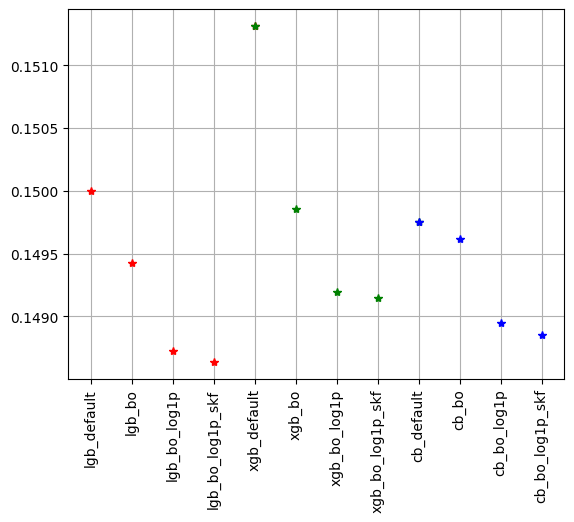

In [93]:
for i, c in zip(range(0, 12, 4), ['r', 'g', 'b']):
    df = metric_df.loc[i:(i+4)]
    plt.plot(df.index, df.rmsle, '*', c=c)

plt.xticks(ticks=metric_df.index, labels=metric_df.model_tag, rotation=90)
plt.grid()

In [130]:
ensemble_model = Ridge()

In [132]:
ensemble_model.fit(oof_df[model_tags], oof_df['Rings'])

Ridge()

In [133]:
simple_ensemble_pred = ensemble_model.predict(pred_df[model_tags])

In [134]:
simple_ensemble_pred

array([ 9.69071961,  9.55985433, 10.20571465, ..., 11.95026242,
       14.0869782 ,  8.32682338])

In [ ]:
def ensemble_cv(oof_df, pred_df, train_cols):
    nfold = 5
    folds = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=42)
    
    oof = np.zeros(oof_df.shape[0])
    pred = np.zeros(pred_df.shape[0])
    
    for i, (trn_idx, val_idx) in enumerate(folds.split(oof_df.index, oof_df.Rings.astype(int))):
        print(f'fold={i}', '- ' * 20)
        trn_X = oof_df.loc[trn_idx, train_cols]
        trn_y = oof_df.loc[trn_idx, 'Rings']

        val_X = oof_df.loc[val_idx, train_cols]
        val_y = oof_df.loc[val_idx, 'Rings']
        
        tst_X = pred_df[train_cols]

        model = Ridge()
        model.fit(trn_X, trn_y)

        oof[val_idx] = model.predict(val_X)
        pred += model.predict(tst_X) / nfold

    cv = mean_squared_log_error(oof_df['Rings'], oof, squared=False)
    return cv, pred

In [ ]:
ensemble_cv, ensemble_pred = ensemble_cv(oof_df, pred_df, model_tags)

In [94]:
ensemble_cv

0.14873459558729193

In [95]:
ensemble_pred

array([ 9.79611278,  9.78543487, 10.00996596, ..., 12.61777516,
       13.94584236,  8.32657144])

## Postprocess

## 提交

In [62]:
sub_df = pd.read_csv('../input/sample_submission.csv')

In [63]:
sub_df.head()

,id,Rings
0,90615,10
1,90616,10
2,90617,10
3,90618,10
4,90619,10


In [64]:
(sub_df['id'] == test_df['id']).all()

True

In [113]:
# 单模型最优
pred_df['Rings'] = pred_df['lgb_bo_log1p']

In [127]:
# ensemble cv pred
pred_df['Rings'] = ensemble_pred

In [136]:
# ensemble simple pred
pred_df['Rings'] = simple_ensemble_pred

In [172]:
# more data pred cv=0.1487
pred_df['Rings'] = pred

In [173]:
cols = ['id', 'Rings']
pred_df[cols].to_csv('more_data_pred.csv', index=False, header=True)

In [175]:
!head more_data_pred.csv

id,Rings
90615,9.837206952449687
90616,9.777940900929194
90617,9.825952536578335
90618,10.639116793945018
90619,7.613494892754508
90620,9.365750582343113
90621,10.682615043884145
90622,6.050469067537613
90623,7.92449544670273


In [67]:
!head ../input/sample_submission.csv

id,Rings
90615,10
90616,10
90617,10
90618,10
90619,10
90620,10
90621,10
90622,10
90623,10
